From: https://mapr.com/blog/deep-learning-tensorflow/

In [1]:
import sys
sys.version

'3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) \n[GCC 7.3.0]'

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import random
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [4]:
tf.__version__

'1.11.0'

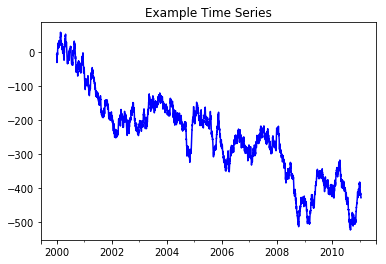

2000-01-01    -6.188025
2000-01-02    -5.644348
2000-01-03   -15.553107
2000-01-04   -25.304335
2000-01-05   -30.279594
2000-01-06   -25.302319
2000-01-07   -16.051155
2000-01-08   -14.404041
2000-01-09    -8.185739
2000-01-10    -3.049675
Freq: D, dtype: float64

In [46]:
random.seed(111)
rng = pd.date_range(start='2000', periods=4039, freq='D')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Example Time Series')
plt.show()
ts.head(10)

In [47]:
TS=np.array(ts)
num_periods = 40
f_horizon = 1
x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = TS[f_horizon:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)

print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

100
(100, 40, 1)
[[[ -6.18802548]
  [ -5.6443481 ]
  [-15.55310703]
  [-25.30433529]
  [-30.27959369]
  [-25.3023185 ]
  [-16.05115497]
  [-14.40404089]
  [ -8.18573882]
  [ -3.0496755 ]
  [ -1.02261362]
  [ -8.07586061]
  [ -0.44005303]
  [  6.00051407]
  [  9.29145711]
  [ 18.04157048]
  [ 12.29627686]
  [ 19.20162873]
  [ 19.22646966]
  [ 27.04665105]
  [ 25.55485122]
  [ 17.8377259 ]
  [ 14.89377383]
  [ 20.50041319]
  [ 17.42034682]
  [ 19.55700447]
  [ 16.5931811 ]
  [ 17.85691102]
  [ 12.99070276]
  [ 20.03012854]
  [ 28.41360611]
  [ 30.0140509 ]
  [ 33.99056905]
  [ 30.79043831]
  [ 30.07735928]
  [ 20.08293105]
  [ 25.34816852]
  [ 27.25429919]
  [ 21.57758261]
  [ 28.7114223 ]]

 [[ 23.91219502]
  [ 24.39429167]
  [ 25.07209424]
  [ 34.21251463]
  [ 32.51809298]
  [ 30.78365587]
  [ 39.01188999]
  [ 41.41305739]
  [ 44.59627938]
  [ 43.70316039]
  [ 51.69861111]
  [ 58.64947365]
  [ 56.8967097 ]
  [ 53.35093282]
  [ 47.17248333]
  [ 56.50644532]
  [ 50.66944055]
  [ 41.58438

In [48]:
testX = TS[-(num_periods + f_horizon):-f_horizon].reshape(-1, num_periods, 1)
testY = TS[-(num_periods):].reshape(-1, num_periods, 1)

In [49]:
print(x_batches[-1])
print(testX)
print(testY)

[[-486.04719706]
 [-485.71751949]
 [-494.04093254]
 [-495.89541595]
 [-497.86352886]
 [-494.69941991]
 [-492.08306617]
 [-501.1746834 ]
 [-495.36503669]
 [-486.81566474]
 [-490.63640081]
 [-485.54136679]
 [-475.74188425]
 [-467.25085762]
 [-467.75356664]
 [-464.87575319]
 [-455.82982323]
 [-457.25028058]
 [-453.39058768]
 [-451.23566699]
 [-449.36137044]
 [-443.62281481]
 [-442.0845159 ]
 [-445.39035581]
 [-438.43757534]
 [-436.00688342]
 [-435.06898272]
 [-433.07678225]
 [-429.79003535]
 [-424.3114632 ]
 [-425.23192897]
 [-416.27615642]
 [-417.84867446]
 [-410.07212259]
 [-417.44672129]
 [-421.18959842]
 [-414.44158329]
 [-414.43257941]
 [-415.26844527]
 [-422.0054832 ]]
[[[-415.26844527]
  [-422.0054832 ]
  [-419.96862814]
  [-427.00327572]
  [-420.65559202]
  [-411.3758235 ]
  [-402.07365816]
  [-403.48161351]
  [-410.69686628]
  [-415.56778063]
  [-416.41655588]
  [-413.38223238]
  [-420.56285008]
  [-412.7160747 ]
  [-403.17321514]
  [-394.09553862]
  [-388.67277915]
  [-384.59860

In [50]:
tf.reset_default_graph()

input_s = 1
hidden = 100
output_s = 1
learning_rate = 0.001

x = tf.placeholder(tf.float32, [None, num_periods, input_s])
y = tf.placeholder(tf.float32, [None, num_periods, output_s])

basic_cell = rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32)
rnn_output = tf.reshape(rnn_output, [-1, hidden])
outputs = tf.layers.dense(rnn_output, output_s)
outputs = tf.reshape(outputs, [-1, num_periods, output_s])

loss = tf.reduce_sum(tf.square(outputs - y))
optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimiser.minimize(loss)

init = tf.global_variables_initializer()

In [51]:
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={x: x_batches, y: y_batches})
        if ep % 10 == 0:
            mse = loss.eval(feed_dict={x: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    ypred = sess.run(outputs, feed_dict={x: testX})
    print(ypred)

0 	MSE: 378315870.0
10 	MSE: 60099656.0
20 	MSE: 9950514.0
30 	MSE: 6747599.0
40 	MSE: 5697919.5
50 	MSE: 4924643.5
60 	MSE: 4248784.0
70 	MSE: 3757105.8
80 	MSE: 3434190.8
90 	MSE: 3152722.2
100 	MSE: 2906944.8
110 	MSE: 2685083.8
120 	MSE: 2461667.8
130 	MSE: 2242806.8
140 	MSE: 2025204.4
150 	MSE: 1815308.4
160 	MSE: 1613020.2
170 	MSE: 1424258.9
180 	MSE: 1243411.2
190 	MSE: 1076657.0
200 	MSE: 926013.9
210 	MSE: 790995.9
220 	MSE: 671327.3
230 	MSE: 567627.1
240 	MSE: 478549.44
250 	MSE: 408602.84
260 	MSE: 345938.44
270 	MSE: 293542.8
280 	MSE: 253406.0
290 	MSE: 222339.03
300 	MSE: 198238.61
310 	MSE: 180118.69
320 	MSE: 166588.4
330 	MSE: 156692.47
340 	MSE: 149549.81
350 	MSE: 144450.8
360 	MSE: 143216.03
370 	MSE: 142009.77
380 	MSE: 135377.69
390 	MSE: 133276.38
400 	MSE: 132154.31
410 	MSE: 131380.88
420 	MSE: 130763.66
430 	MSE: 130347.41
440 	MSE: 130025.086
450 	MSE: 129774.88
460 	MSE: 129551.195
470 	MSE: 129348.89
480 	MSE: 129177.83
490 	MSE: 129026.91
500 	MSE: 1288

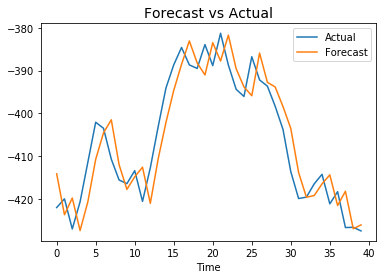

In [52]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(testY)), label="Actual")
plt.plot(pd.Series(np.ravel(ypred)), label="Forecast")
plt.legend(loc="upper right")
plt.xlabel("Time")

plt.show()

In [53]:
print(testY)
print(ypred)

[[[-422.0054832 ]
  [-419.96862814]
  [-427.00327572]
  [-420.65559202]
  [-411.3758235 ]
  [-402.07365816]
  [-403.48161351]
  [-410.69686628]
  [-415.56778063]
  [-416.41655588]
  [-413.38223238]
  [-420.56285008]
  [-412.7160747 ]
  [-403.17321514]
  [-394.09553862]
  [-388.67277915]
  [-384.59860507]
  [-388.67953446]
  [-389.50305678]
  [-383.92709349]
  [-388.84954003]
  [-381.28258462]
  [-388.70385989]
  [-394.38486721]
  [-396.05281626]
  [-386.76817381]
  [-392.18585909]
  [-393.635204  ]
  [-398.3448882 ]
  [-403.74259351]
  [-413.62094401]
  [-419.89310188]
  [-419.56824565]
  [-416.4669819 ]
  [-414.24129118]
  [-421.13189903]
  [-418.29130904]
  [-426.67238409]
  [-426.61131027]
  [-427.45890972]]]
[[[-414.10733]
  [-423.67236]
  [-419.7787 ]
  [-427.37283]
  [-420.6143 ]
  [-410.74948]
  [-404.56754]
  [-401.5004 ]
  [-412.00467]
  [-417.75894]
  [-414.81674]
  [-412.5795 ]
  [-421.01602]
  [-410.6901 ]
  [-402.1369 ]
  [-394.6404 ]
  [-388.55807]
  [-383.07855]
  [-388.